Conditional workflow Exmaple : 
Agentic Review Response System

In [178]:
from langgraph.graph import StateGraph, START , END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict,Literal

In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = "Api key here"

In [180]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative", "neutral"]

    negative_review_analysis:str

    negative_res:str
    positive_res:str
    neutral_res:str


In [181]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature="0.2")

In [ ]:
# NODE Functions 
graph=StateGraph(ReviewState)

class Sentiment_Struct(BaseModel):
    sentiment:Literal["positive","negative","neutral"]=Field(description="sentiment of review out of options : postive, negative, neutral")



class analysis_schema(BaseModel):
    issue_type:str=Field(description="type of the issue raised by the customer from the product review")
    tone_of_review:str=Field(description="the  tone of the customer review")
    urgency_of_customer:str=Field(description="analysed urgency of the customer for the solution")




def sentiment(ReviewState:ReviewState)->Literal["positive","negative","neutral"]:
    prompt="""Based on the following Review of customer Determinine the sentiment of the review from the option "positive" , "negative" ,"neutral" \n
            {Customer_Review}"""
    sentiment_of_review = llm.with_structured_output(Sentiment_Struct).invoke(
        prompt.format(Customer_Review=ReviewState["review"])
    ).sentiment
    return {"sentiment": sentiment_of_review}


def check_sentiment(ReviewState)->Literal["positive_res","negative_review_analysis","neutral_res"]:
    c_sentiment=ReviewState["sentiment"]
    if(c_sentiment=="positive"):
        return "positive_res"
    elif(c_sentiment=="negative"):
        return "negative_review_analysis"
    else :
        return "neutral_res"
    



def positive_res(ReviewState):
    prompt="""You are a product review response creator for Tetra , a technology company that designs and manufactures personalized smartwatches for fitness athletes.

            Your role is to generate clear, professional, and empathetic responses to customer reviews, feedback, and inquiries.address the customer as customer do not user there name Give a appropriate response to the following Review of sentiment {Sentiment} \n" 
            {Customer_Review}"""
    response = llm.invoke(
        prompt.format(Sentiment=ReviewState["sentiment"], Customer_Review=ReviewState["review"])
    ).content
    return {"positive_res": response}

def neutral_res(ReviewState):
    prompt="""You are a product review response creator for Tetra , a technology company that designs and manufactures personalized smartwatches for fitness athletes.

             Your role is to generate clear, professional, and empathetic responses to customer reviews, feedback, and inquiries.address the customer as customer do not user there name Give a appropriate response to the following Review of sentiment {Sentiment} \n" 
            {Customer_Review}"""
    response = llm.invoke(
        prompt.format(Sentiment=ReviewState["sentiment"], Customer_Review=ReviewState["review"])
    ).content
    return {"neutral_res": response}





def negative_res(ReviewState):
    prompt="""You are a product review response creator for Tetra , a technology company that designs and manufactures personalized smartwatches for fitness athletes.

             Your role is to generate clear, professional, and empathetic responses to customer reviews, feedback, and inquiries. address the customer as customer do not user there name    Give a appropriate response to the following Review of sentiment type {Sentiment}  based on the analysis report report:{report} \n" 
            review:{Customer_Review}"""
    response = llm.invoke(
        prompt.format(Sentiment=ReviewState["sentiment"],
                      report=ReviewState["negative_review_analysis"],
                      Customer_Review=ReviewState["review"])
    ).content
    return {"negative_res": response}


import json



def negative_review_analysis(ReviewState):
    prompt="""conduct a analysis on the the negative review  of the  following customer Review and provide the analysis in a schema of factors "issue type", "tone of the review","urgency of the customer" \n" 
            {Customer_Review}"""
    
    response = llm.with_structured_output(analysis_schema).invoke(
        prompt.format(Customer_Review=ReviewState["review"])
    )
    report_str = json.dumps(response.model_dump(), indent=2)
    return {"negative_review_analysis": report_str}


    



In [183]:


graph.add_node("sentiment",sentiment)
graph.add_node("negative_res",negative_res)
graph.add_node("negative_review_analysis",negative_review_analysis)
graph.add_node("positive_res",positive_res)
graph.add_node("neutral_res",neutral_res)



graph.add_edge(START,"sentiment")
graph.add_conditional_edges("sentiment",check_sentiment)

graph.add_edge("positive_res",END)
graph.add_edge("negative_review_analysis","negative_res")
graph.add_edge("neutral_res",END)
graph.add_edge("negative_res",END)

In [184]:
workflow = graph.compile()

In [185]:
from pprint import pprint

In [186]:

result=workflow.invoke({"review":"""I’ve been using this smartwatch for a while, and overall the experience has been disappointing. While it offers basic fitness tracking features, the accuracy of some metrics feels inconsistent, especially during longer or more intense workouts.The interface can feel slow at times, and navigation isn’t always intuitive. Customization options are limited, which makes the watch feel less personalized than expected. Battery life is another concern, as it often requires charging more frequently than advertised when fitness tracking is used regularly.The build quality is acceptable, but it doesn’t feel as durable or premium as other fitness-focused smartwatches in this price range. Overall, the watch may work for basic use, but it falls short for athletes who expect reliable performance, smooth usability, and long-term durability."""})
pprint(result,width=100)

{'negative_res': 'Dear Customer,\n'
                 '\n'
                 'Thank you for taking the time to share your detailed feedback regarding your '
                 'experience with your Tetra smartwatch. We sincerely apologize that your '
                 'experience has been disappointing and has not met your expectations, '
                 'particularly as a fitness athlete.\n'
                 '\n'
                 'We understand your concerns about the inconsistent accuracy of fitness tracking '
                 'during intense workouts, the slow interface, and the navigation not being '
                 'intuitive. We also acknowledge your feedback regarding the limited customization '
                 'options, the battery life falling short of expectations with regular fitness '
                 'tracking, and the overall durability not feeling sufficient for dedicated '
                 'athletic use.\n'
                 '\n'
                 'Please know that we are c

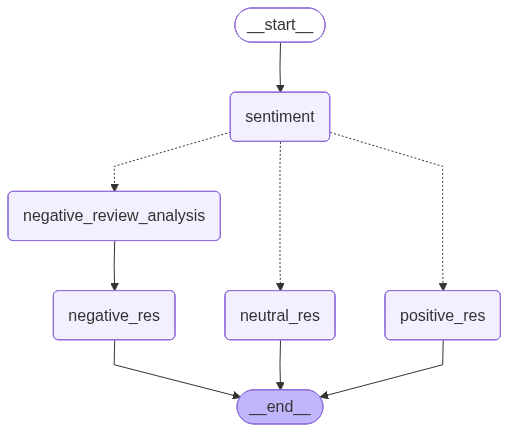

In [187]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())
